# **1. Setup & Library Imports**

In [1]:
import os
import math
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from tqdm import tqdm
from diffusers import AutoencoderKL
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTokenizer, CLIPTextModel
import torch.optim.lr_scheduler as lr_scheduler
from torch.amp import GradScaler, autocast

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")

set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Seed set to 42
cuda


In [3]:
# Download emoji dataset
# https://drive.google.com/file/d/15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h/view?usp=sharing
!gdown 15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h
!unzip blobs_crawled_data.zip

Downloading...
From (original): https://drive.google.com/uc?id=15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h
From (redirected): https://drive.google.com/uc?id=15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h&confirm=t&uuid=02c16ab4-dc4c-4c54-8cf2-c74a6b1cd351
To: /content/blobs_crawled_data.zip
100% 12.5M/12.5M [00:00<00:00, 116MB/s]
Archive:  blobs_crawled_data.zip
   creating: blobs_crawled_data/
  inflating: blobs_crawled_data/metadata.csv  
   creating: blobs_crawled_data/images/
 extracting: blobs_crawled_data/images/Blobs_0002712.jpg  
  inflating: blobs_crawled_data/images/Blobs_0003414.jpg  
 extracting: blobs_crawled_data/images/Blobs_0006860.jpg  
 extracting: blobs_crawled_data/images/Blobs_0000636.jpg  
 extracting: blobs_crawled_data/images/Blobs_0001219.jpg  
 extracting: blobs_crawled_data/images/Blobs_0005969.jpg  
 extracting: blobs_crawled_data/images/Blobs_0007068.jpg  
 extracting: blobs_crawled_data/images/Blobs_0000014.jpg  
 extracting: blobs_crawled_data/images/Blobs_0003213.jpg  
 extrac

# **2. Attention Mechanism**

## 2.1 Self-Attention

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, num_attn_heads, hidden_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.num_heads = num_attn_heads
        self.head_size = hidden_dim // num_attn_heads

        self.qkv_proj = nn.Linear(hidden_dim, 3 * hidden_dim, bias=in_proj_bias)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim, bias=out_proj_bias)

    def forward(self, features, use_causal_mask=False):
        b, s, d = features.shape

        qkv_combined = self.qkv_proj(features)
        q_mat, k_mat, v_mat = torch.chunk(qkv_combined, 3, dim=-1)

        q_mat = q_mat.view(b, s, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        k_mat = k_mat.view(b, s, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        v_mat = v_mat.view(b, s, self.num_heads, self.head_size).permute(0, 2, 1, 3)

        qk = torch.matmul(q_mat, k_mat.transpose(-2, -1))
        sqrt_qk = qk / math.sqrt(self.head_size)

        if use_causal_mask:
            causal_mask = torch.triu(torch.ones_like(sqrt_qk, dtype=torch.bool), diagonal=1)
            sqrt_qk = sqrt_qk.masked_fill(causal_mask, -torch.inf)

        attn_weights = torch.softmax(sqrt_qk, dim=-1)
        attn_values = torch.matmul(attn_weights, v_mat)

        attn_values = attn_values.permute(0, 2, 1, 3).contiguous()
        attn_values = attn_values.view(b, s, d)

        final_output = self.output_proj(attn_values)
        return final_output


## 2.2 Cross-Attention

In [5]:
class CrossAttention(nn.Module):
    def __init__(self, num_attn_heads, query_dim, context_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.num_heads = num_attn_heads
        self.head_size = query_dim // num_attn_heads

        self.query_map = nn.Linear(query_dim, query_dim, bias=in_proj_bias)
        self.key_map = nn.Linear(context_dim, query_dim, bias=in_proj_bias)
        self.value_map = nn.Linear(context_dim, query_dim, bias=in_proj_bias)

        self.output_map = nn.Linear(query_dim, query_dim, bias=out_proj_bias)

    def forward(self, query_input, context_input):
        b_q, s_q, d_q = query_input.shape
        _, s_kv, _ = context_input.shape

        q_mat = self.query_map(query_input)
        k_mat = self.key_map(context_input)
        v_mat = self.value_map(context_input)

        q_mat = q_mat.view(b_q, s_q, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        k_mat = k_mat.view(b_q, s_kv, self.num_heads, self.head_size).permute(0, 2, 1, 3)
        v_mat = v_mat.view(b_q, s_kv, self.num_heads, self.head_size).permute(0, 2, 1, 3)

        qk = torch.matmul(q_mat, k_mat.transpose(-2, -1))
        sqrt_qk = qk / math.sqrt(self.head_size)
        attn_weights = torch.softmax(sqrt_qk, dim=-1)

        attn_values = torch.matmul(attn_weights, v_mat)
        attn_values = attn_values.permute(0, 2, 1, 3).contiguous()
        attn_values = attn_values.view(b_q, s_q, d_q)

        final_output = self.output_map(attn_values)
        return final_output

# **3. Stable Diffusion**

## **3.1 DDPM - Denoising Diffusion Probabilistic Model**

In [6]:
class DDPMScheduler:
    def __init__(
        self,
        random_generator,
        train_timesteps=1000,
        diffusion_beta_start=0.00085,
        diffusion_beta_end=0.012
    ):

        self.betas = torch.linspace(
            diffusion_beta_start ** 0.5, diffusion_beta_end ** 0.5, train_timesteps,
            dtype=torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alphas_cumulative_product = torch.cumprod(self.alphas, dim=0)
        self.one_val = torch.tensor(1.0)
        self.prng_generator = random_generator
        self.total_train_timesteps = train_timesteps
        self.schedule_timesteps = torch.from_numpy(np.arange(0, train_timesteps)[::-1].copy())

    def set_steps(self, num_sampling_steps=50):
        self.num_sampling_steps = num_sampling_steps
        step_scaling_factor = self.total_train_timesteps // self.num_sampling_steps
        timesteps_for_sampling = (
            np.arange(0, num_sampling_steps) * step_scaling_factor
        ).round()[::-1].copy().astype(np.int64)
        self.schedule_timesteps = torch.from_numpy(timesteps_for_sampling)

    def _get_prior_timestep(self, current_timestep):
        previous_t = current_timestep - self.total_train_timesteps // self.num_sampling_steps
        return previous_t

    def _calculate_variance(self, timestep):
        prev_t = self._get_prior_timestep(timestep)
        alpha_cumprod_t = self.alphas_cumulative_product[timestep]
        alpha_cumprod_t_prev = self.alphas_cumulative_product[prev_t] if prev_t >= 0 else self.one_val
        beta_t_current = 1 - alpha_cumprod_t / alpha_cumprod_t_prev
        variance_value = (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * beta_t_current
        variance_value = torch.clamp(variance_value, min=1e-20)
        return variance_value

    def adjust_strength(self, strength_level=1):
        initial_step_index = self.num_sampling_steps - int(self.num_sampling_steps * strength_level)
        self.schedule_timesteps = self.schedule_timesteps[initial_step_index:]
        self.start_sampling_step = initial_step_index # Lưu lại bước bắt đầu

    def step(self, current_t, current_latents, model_prediction):
        t = current_t
        prev_t = self._get_prior_timestep(t)

        alpha_cumprod_t = self.alphas_cumulative_product[t]
        alpha_cumprod_t_prev = self.alphas_cumulative_product[prev_t] if prev_t >= 0 else self.one_val
        beta_cumprod_t = 1 - alpha_cumprod_t
        beta_cumprod_t_prev = 1 - alpha_cumprod_t_prev
        alpha_t_current = alpha_cumprod_t / alpha_cumprod_t_prev
        beta_t_current = 1 - alpha_t_current

        predicted_original = (current_latents - beta_cumprod_t ** 0.5 * model_prediction) / alpha_cumprod_t ** 0.5

        original_coeff = (alpha_cumprod_t_prev ** 0.5 * beta_t_current) / beta_cumprod_t
        current_coeff = alpha_t_current ** 0.5 * beta_cumprod_t_prev / beta_cumprod_t

        predicted_prior_mean = original_coeff * predicted_original + current_coeff * current_latents

        variance_term = 0
        if t > 0:
            target_device = model_prediction.device
            noise_component = torch.randn(
                model_prediction.shape,
                generator=self.prng_generator,
                device=target_device,
                dtype=model_prediction.dtype
            )
            variance_term = (self._calculate_variance(t) ** 0.5) * noise_component

        predicted_prior_sample = predicted_prior_mean + variance_term
        return predicted_prior_sample

    def add_noise(self, initial_samples, noise_timesteps):
        alphas_cumprod = self.alphas_cumulative_product.to(
            device=initial_samples.device,
            dtype=initial_samples.dtype
        )
        noise_timesteps = noise_timesteps.to(initial_samples.device)
        sqrt_alpha_cumprod = alphas_cumprod[noise_timesteps] ** 0.5
        sqrt_alpha_cumprod = sqrt_alpha_cumprod.view(
            sqrt_alpha_cumprod.shape[0], *([1] * (initial_samples.ndim - 1))
        )
        sqrt_one_minus_alpha_cumprod = (1 - alphas_cumprod[noise_timesteps]) ** 0.5
        sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.view(
            sqrt_one_minus_alpha_cumprod.shape[0], *([1] * (initial_samples.ndim - 1))
        )
        random_noise = torch.randn(
            initial_samples.shape, generator=self.prng_generator,
            device=initial_samples.device, dtype=initial_samples.dtype
        )
        noisy_result = sqrt_alpha_cumprod * initial_samples + sqrt_one_minus_alpha_cumprod * random_noise
        return noisy_result, random_noise


## **3.2 UNet Architecture**

### 3.2.1 Residual Block

In [7]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=1280):
        super().__init__()
        self.gn_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.time_embedding_proj = nn.Linear(time_dim, out_channels)

        self.gn_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_connection = nn.Identity()
        else:
            self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, input_feature, time_emb):
        residual = input_feature

        h = self.gn_feature(input_feature)
        h = F.silu(h)
        h = self.conv_feature(h)

        time_emb_processed = F.silu(time_emb)
        time_emb_projected = self.time_embedding_proj(time_emb_processed)
        time_emb_projected = time_emb_projected.unsqueeze(-1).unsqueeze(-1)

        merged_feature = h + time_emb_projected
        merged_feature = self.gn_merged(merged_feature)
        merged_feature = F.silu(merged_feature)
        merged_feature = self.conv_merged(merged_feature)

        output = merged_feature + self.residual_connection(residual)
        return output


### 3.2.2 Attention Block

In [8]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, num_heads, head_dim, context_dim=512):
        super().__init__()
        embed_dim = num_heads * head_dim

        self.gn_in = nn.GroupNorm(32, embed_dim, eps=1e-6)
        self.proj_in = nn.Conv2d(embed_dim, embed_dim, kernel_size=1, padding=0)

        self.ln_1 = nn.LayerNorm(embed_dim)
        self.attn_1 = SelfAttention(num_heads, embed_dim, in_proj_bias=False)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn_2 = CrossAttention(num_heads, embed_dim, context_dim, in_proj_bias=False)
        self.ln_3 = nn.LayerNorm(embed_dim)

        self.ffn_geglu = nn.Linear(embed_dim, 4 * embed_dim * 2)
        self.ffn_out = nn.Linear(4 * embed_dim, embed_dim)
        self.proj_out = nn.Conv2d(embed_dim, embed_dim, kernel_size=1, padding=0)

    def forward(self, input_tensor, context_tensor):
        skip_connection = input_tensor

        B, C, H, W = input_tensor.shape
        HW = H * W

        h = self.gn_in(input_tensor)
        h = self.proj_in(h)
        h = h.view(B, C, HW).transpose(-1, -2)

        attn1_skip = h
        h = self.ln_1(h)
        h = self.attn_1(h)
        h = h + attn1_skip

        attn2_skip = h
        h = self.ln_2(h)
        h = self.attn_2(h, context_tensor)
        h = h + attn2_skip

        ffn_skip = h
        h = self.ln_3(h)
        intermediate, gate = self.ffn_geglu(h).chunk(2, dim=-1)
        h = intermediate * F.gelu(gate)
        h = self.ffn_out(h)
        h = h + ffn_skip

        h = h.transpose(-1, -2).view(B, C, H, W)
        output = self.proj_out(h) + skip_connection
        return output


In [9]:
class Upsample(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, feature_map):
        x = F.interpolate(feature_map, scale_factor=2, mode='nearest')
        x = self.conv(x)
        return x


class SwitchSequential(nn.Sequential):
    def forward(self, x, guidance_context, time_embedding):
        for module_instance in self:
            if isinstance(module_instance, UNET_AttentionBlock):
                x = module_instance(x, guidance_context)
            elif isinstance(module_instance, UNET_ResidualBlock):
                x = module_instance(x, time_embedding)
            else:
                x = module_instance(x)
        return x


class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.proj1 = nn.Linear(n_embd, 4 * n_embd)
        self.proj2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        x = self.proj1(x)
        x = F.silu(x)
        x = self.proj2(x)
        return x

In [10]:
class UNET(nn.Module):
    def __init__(self, h_dim, n_head):
        super().__init__()

        self.down_blocks = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, h_dim, kernel_size=3, padding=1)),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, h_dim),
                UNET_AttentionBlock(n_head, (h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, h_dim),
                UNET_AttentionBlock(n_head, (h_dim)//n_head)
            ),
            SwitchSequential(nn.Conv2d(h_dim, h_dim, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(
                UNET_ResidualBlock(h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(nn.Conv2d(2*h_dim, 2*h_dim, kernel_size=3, stride=2, padding=1)),
            SwitchSequential(UNET_ResidualBlock(2*h_dim, 4*h_dim)),
            SwitchSequential(UNET_ResidualBlock(4*h_dim, 4*h_dim)),
        ])

        self.mid_block = SwitchSequential(
            UNET_ResidualBlock(4*h_dim, 4*h_dim),
            UNET_AttentionBlock(n_head, (4*h_dim)//n_head),
            UNET_ResidualBlock(4*h_dim, 4*h_dim),
        )

        self.up_blocks = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(4*h_dim + 4*h_dim, 4*h_dim)),
            SwitchSequential(UNET_ResidualBlock(4*h_dim + 4*h_dim, 4*h_dim)),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim + 2*h_dim, 4*h_dim),
                Upsample(4*h_dim)
            ),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim + 2*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(4*h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim + h_dim, 2*h_dim),
                UNET_AttentionBlock(n_head, (2*h_dim)//n_head),
                Upsample(2*h_dim)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim + h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
            SwitchSequential(
                UNET_ResidualBlock(2*h_dim, h_dim),
                UNET_AttentionBlock(n_head, h_dim//n_head)
            ),
        ])

    def forward(self, latent_input, context_embedding, time_embedding):
        down_block_residuals = []
        current_feature_map = latent_input

        for block in self.down_blocks:
            current_feature_map = block(
                current_feature_map,
                context_embedding,
                time_embedding
            )
            down_block_residuals.append(current_feature_map)

        current_feature_map = self.mid_block(
            current_feature_map,
            context_embedding,
            time_embedding
        )

        for block in self.up_blocks:
            residual = down_block_residuals.pop()
            current_feature_map = torch.cat((current_feature_map, residual), dim=1)
            current_feature_map = block(
                current_feature_map,
                context_embedding,
                time_embedding
            )

        return current_feature_map


class UNETOutputLayer(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.final_groupnorm = nn.GroupNorm(32, input_channels)
        self.final_conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, feature_map):
        norm_map = self.final_groupnorm(feature_map)
        activated_map = F.silu(norm_map)
        output_map = self.final_conv(activated_map)

        return output_map

## **3.3 Timestep Handling**

In [11]:
def embed_a_timestep(timestep, embedding_dim=320):
    half_dim = embedding_dim // 2
    freqs = torch.exp(-math.log(10000) *
                      torch.arange(start=0, end=half_dim, dtype=torch.float32) /
                      half_dim)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

def embed_timesteps(timesteps, embedding_dim=320):
    half_dim = embedding_dim // 2
    freqs = torch.exp(-math.log(10000) *
                      torch.arange(half_dim, dtype=torch.float32) /
                      half_dim).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None, :]
    return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

## **3.4 Diffusion Process**

In [12]:
class Diffusion(nn.Module):
    def __init__(self, h_dim=128, n_head=4):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET(h_dim, n_head)
        self.unet_output = UNETOutputLayer(h_dim, 4)

    @torch.autocast(
        device_type='cuda', dtype=torch.float16,
        enabled=True, cache_enabled=True
    )
    def forward(self, latent, context, time):
        time = self.time_embedding(time)
        output = self.unet(latent, context, time)
        output = self.unet_output(output)
        return output

## **3.5 CLIP - Contrastive Language-Image Pre-Training**

In [13]:
class CLIPTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        CLIP_id = "openai/clip-vit-base-patch32"
        self.tokenizer = CLIPTokenizer.from_pretrained(CLIP_id)
        self.text_encoder = CLIPTextModel.from_pretrained(CLIP_id)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        for param in self.text_encoder.parameters():
            param.requires_grad = False

        self.text_encoder.eval()
        self.text_encoder.to(self.device)

    def forward(self, prompts):
        inputs = self.tokenizer(
            prompts,
            padding="max_length",
            truncation=True,
            max_length=self.text_encoder.config.max_position_embeddings,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids.to(self.device)
        attention_mask = inputs.attention_mask.to(self.device)

        with torch.no_grad():
            text_encoder_output = self.text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        last_hidden_states = text_encoder_output.last_hidden_state

        return last_hidden_states

## **3.6. VAE - Variational Autoencoder**

In [14]:
VAE_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(VAE_id)
vae.requires_grad_(False)
vae.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

# **4. Utility Functions**

In [15]:
def show_images(images, title="", titles=[]):
    plt.figure(figsize=(8, 8))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def rescale(value, in_range, out_range, clamp=False):
    in_min, in_max = in_range
    out_min, out_max = out_range

    in_span = in_max - in_min
    out_span = out_max - out_min

    scaled_value = (value - in_min) / (in_span + 1e-8)
    rescaled_value = out_min + (scaled_value * out_span)

    if clamp:
        rescaled_value = torch.clamp(
            rescaled_value,
            out_min, out_max
        )

    return rescaled_value

# **5. Dataset Preparation**

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch images shape: torch.Size([32, 3, 32, 32])
blobcat_Roll emoji with a round head, small black eyes, slightly open mouth, neutral expression, orange skin color, no action, with a white background.
Blob_Nuzzle emoji with a round head, closed eyes, small mouth, content expression, yellow skin color, no action, with a white background.
Pride Blob emoji with a round head, small black eyes, winking mouth, happy expression, yellow skin color, no action, with a white background.
Blobhaj_Glare emoji with a rounded head, black oval eyes, small curved mouth, sad expression, white skin color, no action, with a white background.
DNS BluePurpleBlob emoji with a round head, large circular eyes, slightly open mouth, neutral expression, blue-purple skin color, no action, with a light blue background.
BlobDance emoji with a round head, small black eyes, smiling mouth, happy expression, black skin color, no action, with a black background.
Blobbellsprout emoji with a round head, small round eyes, ope

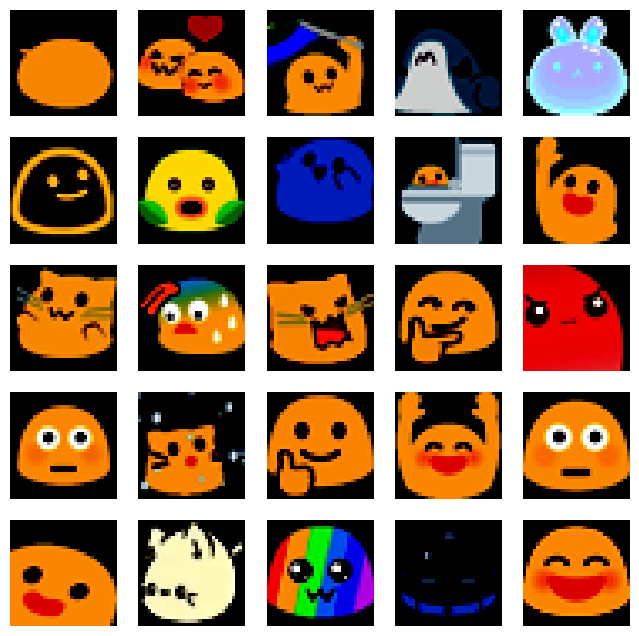

In [16]:
WIDTH, HEIGHT = 32, 32
batch_size = 32

class EmojiDataset(Dataset):
    def __init__(self, csv_files, image_folder, transform=None):
        self.dataframe = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files])
        self.images_folder = image_folder
        self.dataframe['image_path'] = self.dataframe['file_name'].str.replace('\\', '/')
        self.image_paths = self.dataframe['image_path'].tolist()
        self.titles = self.dataframe['prompt'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.images_folder + '/' + self.image_paths[idx]
        title = self.titles[idx]
        title = title.replace('"', '').replace("'", '')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, title

transform = transforms.Compose([
    transforms.Resize(
        (WIDTH, HEIGHT),
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

csv_files = ['/content/blobs_crawled_data/metadata.csv']
image_folder = '/content/blobs_crawled_data/images'

train_dataset = EmojiDataset(
    csv_files=csv_files,
    image_folder=image_folder,
    transform=transform
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

dataiter = iter(train_dataloader)
images, titles = next(dataiter)

print(f"Batch images shape: {images.shape}")

clipped_images = torch.clamp(images, 0, 1)
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(clipped_images[i].permute(1, 2, 0).numpy())
    print(titles[i])
    plt.axis('off')
plt.show()


# **6. Model Training**

In [17]:
def train(diffusion, vae, text_encoder, scheduler,
          optimizer, lr_scheduler, scaler,
          criterion, dataloader, num_epochs, device="cuda"):
    losses = []
    for epoch in range(num_epochs):
        diffusion.train()

        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (images, titles) in enumerate(progress_bar):
            images = images.to(device)
            image_titles = [f"A photo of {title}" for title in titles]
            # 50% image_titles là chuỗi rỗng
            image_titles = [title if random.random() < 0.5 else "" for title in image_titles]

            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample() * 0.18215

            timesteps = torch.randint(
                0, scheduler.total_train_timesteps,
                 (latents.shape[0],), device=device
            )

            noisy_latents, noise = scheduler.add_noise(latents, timesteps)
            time_embeddings = embed_timesteps(timesteps).to(device)
            text_embeddings = text_encoder(image_titles)

            noise_pred = diffusion(noisy_latents, text_embeddings, time_embeddings)

            with autocast(device_type='cuda', dtype=torch.float16,
                          enabled=True, cache_enabled=True):
                loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            epoch_loss += batch_loss

            progress_bar.set_postfix(loss=f"{batch_loss:.5f}",
                                     lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        lr_scheduler.step()
        avg_epoch_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_epoch_loss:.5f}")
        losses.append(avg_epoch_loss)

    print("Training finished!")
    return losses

In [18]:
EPOCHS = 300

h_dim = 384
n_head = 8

vae = vae.to(device)
diffusion = Diffusion(h_dim, n_head).to(device)
clip = CLIPTextEncoder().to(device)

random_generator = torch.Generator(device='cuda')
noise_scheduler = DDPMScheduler(random_generator)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

lrate_scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS, eta_min=1e-5
)
scaler = GradScaler()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

vae_params = count_parameters(vae)
diffusion_params = count_parameters(diffusion)
clip_params = count_parameters(clip)

print(f"VAE parameters: {vae_params}")
print(f"Diffusion parameters: {diffusion_params}")
print(f"CLIP parameters: {clip_params}")
print(f"Total parameters: {vae_params + diffusion_params + clip_params}")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

VAE parameters: 83653863
Diffusion parameters: 631718020
CLIP parameters: 63165952
Total parameters: 778537835


In [19]:
losses = train(diffusion, vae, clip, noise_scheduler,
               optimizer, lrate_scheduler, scaler,
               criterion, train_dataloader, EPOCHS, device=device)

Epoch [1/300] - Avg Loss: 0.32506


Epoch [10/300] - Avg Loss: 0.20489


Epoch [20/300] - Avg Loss: 0.18876


Epoch [30/300] - Avg Loss: 0.17725


Epoch [40/300] - Avg Loss: 0.15956


Epoch [50/300] - Avg Loss: 0.15959


Epoch [60/300] - Avg Loss: 0.15254


Epoch [70/300] - Avg Loss: 0.14534


Epoch [80/300] - Avg Loss: 0.13452


Epoch [90/300] - Avg Loss: 0.12792


Epoch [100/300] - Avg Loss: 0.12816


Epoch [110/300] - Avg Loss: 0.11793


Epoch [120/300] - Avg Loss: 0.11691


Epoch [130/300] - Avg Loss: 0.11063


Epoch [140/300] - Avg Loss: 0.10601


Epoch [150/300] - Avg Loss: 0.09734


Epoch [160/300] - Avg Loss: 0.09529


Epoch [170/300] - Avg Loss: 0.08846


Epoch [180/300] - Avg Loss: 0.08732


Epoch [190/300] - Avg Loss: 0.07940


Epoch [200/300] - Avg Loss: 0.08037


Epoch [210/300] - Avg Loss: 0.07362


Epoch [220/300] - Avg Loss: 0.06963


Epoch [230/300] - Avg Loss: 0.06613


Epoch [240/300] - Avg Loss: 0.06586


Epoch [250/300] - Avg Loss: 0.06196


Epoch [260/300] - Avg Loss: 0.05954


Epoch [270/300] - Avg Loss: 0.05720


Epoch [280/300] - Avg Loss: 0.05424


Epoch [290/300] - Avg Loss: 0.05594


Epoch [300/300] - Avg Loss: 0.05491
Training finished!


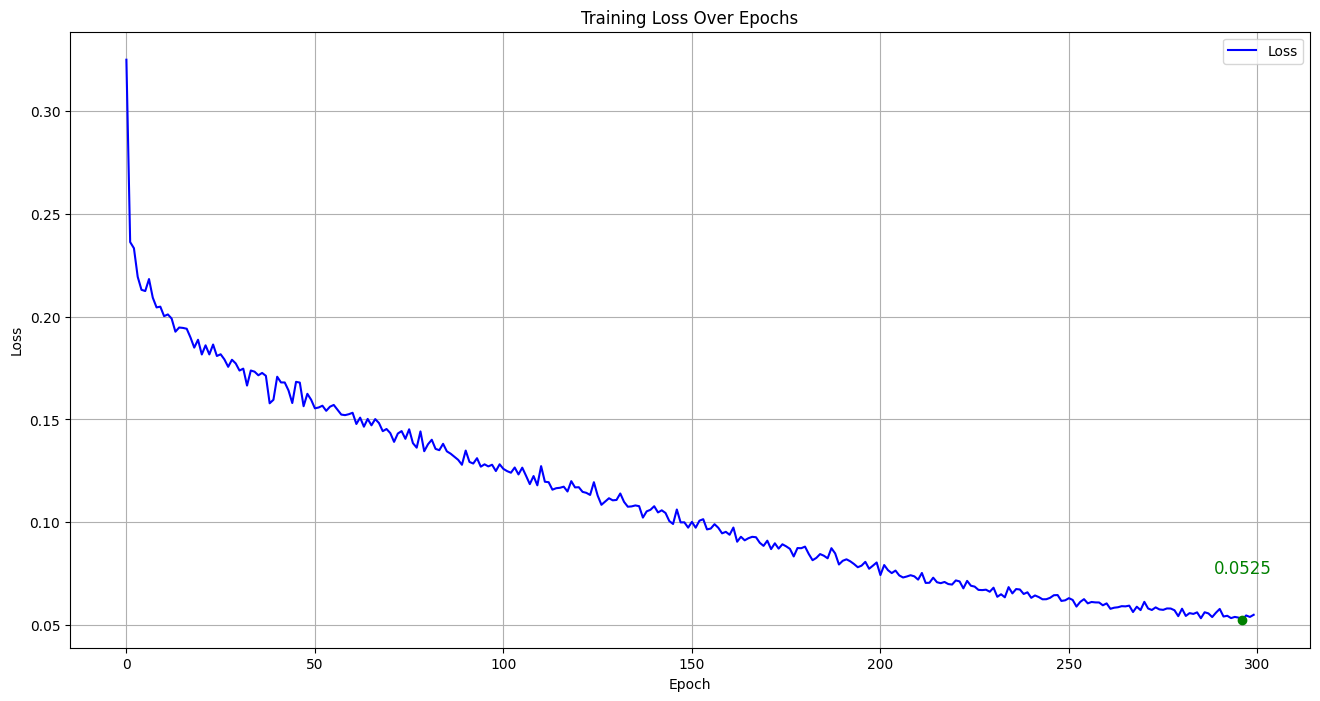

In [20]:
plt.figure(figsize=(16, 8))

plt.plot(losses, label='Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

min_loss = min(losses)
min_loss_epoch = losses.index(min_loss)
plt.scatter(min_loss_epoch, min_loss, color='green', zorder=5)
plt.text(min_loss_epoch,
         min_loss+0.025,
         f'{min_loss:.4f}',
         fontsize=12,
         verticalalignment='center',
         horizontalalignment='center',
         color='green')

plt.legend()
plt.grid()
plt.savefig('training_loss.png')
plt.show()


# **7. Model Checkpointing**

In [21]:
torch.save(diffusion.state_dict(), "diffusion_model_emoji.pth")
!zip -r diffusion_model_emoji.zip diffusion_model_emoji.pth

  adding: diffusion_model_emoji.pth (deflated 8%)


In [22]:
# https://drive.google.com/file/d/1L7NiTeK5veX7A7ynux7vwZjx7b_ta5ur/view?usp=drive_link
!gdown 1L7NiTeK5veX7A7ynux7vwZjx7b_ta5ur

Downloading...
From (original): https://drive.google.com/uc?id=1L7NiTeK5veX7A7ynux7vwZjx7b_ta5ur
From (redirected): https://drive.google.com/uc?id=1L7NiTeK5veX7A7ynux7vwZjx7b_ta5ur&confirm=t&uuid=7c494324-f437-40a6-8e44-ecee4e188591
To: /content/diffusion_model_emoji.pth
100% 2.53G/2.53G [00:33<00:00, 74.4MB/s]


In [23]:
h_dim = 384
n_head = 8

VAE_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(VAE_id)
vae.requires_grad_(False)
vae.eval()
vae = vae.to(device)

clip = CLIPTextEncoder().to(device)
clip.eval()

diffusion = Diffusion(h_dim, n_head).to(device)
diffusion.load_state_dict(torch.load("diffusion_model_emoji.pth"))
diffusion.eval()

random_generator = torch.Generator(device='cuda')
noise_scheduler = DDPMScheduler(random_generator)

# **8. Image Generation**

In [24]:
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generate_image(
    prompt,
    diffusion,
    vae,
    text_encoder,
    scheduler,
    num_inference_steps=100,
    seed=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
):
    rng_generator = torch.Generator(device=device)
    if seed is None:
        rng_generator.seed()
    else:
        rng_generator.manual_seed(seed)

    prompts = [prompt]
    text_embeddings = text_encoder(prompts).to(device)

    scheduler.set_steps(num_inference_steps)

    latent_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

    noisy_latents = torch.randn(
        latent_shape, generator=rng_generator, device=device)
    timesteps = scheduler.schedule_timesteps

    for t in tqdm(timesteps):
        latent_model_input = noisy_latents

        time_embedding = embed_a_timestep(t).to(device)

        with torch.no_grad():
            noise_pred = diffusion(
                latent_model_input,
                text_embeddings,
                time_embedding
            )
        noisy_latents = scheduler.step(
            t,
            noisy_latents,
            noise_pred
        )

    final_latents = noisy_latents / 0.18215

    with torch.no_grad():
        decoded_image_tensor = vae.decode(final_latents).sample

    image_output = rescale(decoded_image_tensor, (-1, 1), (0, 255), clamp=True)
    image_output = image_output.permute(0, 2, 3, 1).to("cpu", torch.uint8).numpy()
    return image_output[0]

100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


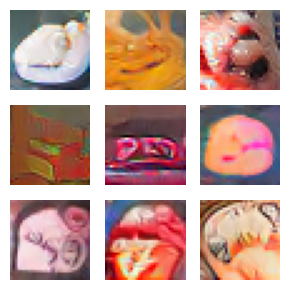

In [25]:
user_inputs = prompts = [
    "a happy blob emoji with sparkling eyes open mouth showing tongue, green skin, floating, purple background",
    "an angry blob emoji with narrowed eyes frowning mouth, orange skin, wearing a party hat, white background",
    "a confused blob emoji with wide eyes slightly open mouth, yellow skin, pointing at his head and wearing a star-shaped crown, dark blue background",
    "a sad blob emoji with droopy eyes frowning mouth, green skin, waving hand and wearing red pom-poms, white background",
    "a grumpy blob emoji with half-closed eyes frowning mouth, purple skin, wielding a large knife, red background",
    "a happy blob emoji with teary eyes smiling mouth, pink skin, wearing a sombrero, white background",
    "a devilish blob emoji with red eyes wide open mouth showing tongue, red skin, wearing horns and hugging a teddy bear, warm background with a fireplace and autumn leaves",
    "a cozy blob emoji with half-closed eyes slightly open mouth, orange skin, holding a steaming cup of coffee and making a fist, warm background with a fireplace and autumn leaves",
    "a surprised blob emoji with wide eyes open mouth, yellow skin, wearing a purple hoodie and sitting on its hind legs, blue background",
]

fig, axes = plt.subplots(3, 3, figsize=(3, 3))
axes = axes.flatten()
for i, user_input in enumerate(user_inputs[:9]):
    prompt = f"A photo of {user_input.lower()}"
    img = generate_image(prompt, diffusion, vae, clip, noise_scheduler, num_inference_steps=100)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


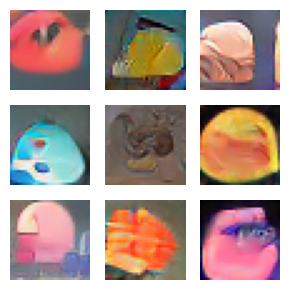

In [26]:
user_inputs = [
    "a sad blob emoji with droopy eyes, frowning mouth, brown skin, wearing a party hat, red background",
    "a sleepy blob emoji with closed eyes, frowning mouth, green skin, sitting on its hind legs, white background",
    "a curious blob emoji with half-closed eyes, slightly open mouth, yellow skin, pointing finger upwards, dark blue background",
    "a happy blob emoji with bright blue eyes, wide open mouth, green skin, hanging from a string, white background",
    "a confused blob emoji with wide eyes, slightly open mouth, yellow skin, wearing a red bow tie, white background",
    "a grumpy blob emoji with half-closed eyes, wide open mouth showing teeth, yellow skin, light blue background with red hearts around",
    "a happy blob emoji with wide open eyes, smiling mouth, pink skin, sitting on a blue ribbon, white background",
    "a laughing blob emoji with closed eyes, wide open mouth, orange skin, holding a thermometer, white background",
    "a cool blob emoji with sunglasses, smiling mouth, pink skin, wearing horns, purple background",
]

fig, axes = plt.subplots(3, 3, figsize=(3, 3))
axes = axes.flatten()
for i, user_input in enumerate(user_inputs[:9]):
    prompt = f"A photo of {user_input.lower()}"
    img = generate_image(prompt, diffusion, vae, clip, noise_scheduler, num_inference_steps=100)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


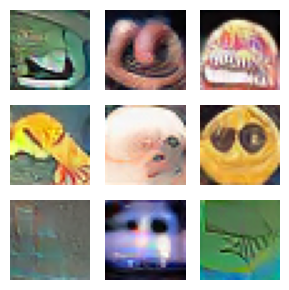

In [27]:
user_inputs = [
    "a sleepy blob emoji with closed eyes, smiling mouth, green skin, holding a teddy bear, purple background",
    "an angry blob emoji with wide open eyes, showing teeth, gray skin, wearing a sombrero, red background",
    "a confused blob emoji with wide eyes, slightly open mouth, pink skin, holding a sign that says SIMP, dark blue background",
    "a grumpy blob emoji with half-closed eyes, frowning mouth, green skin, eating popcorn while wearing a sleeping mask, white background",
    "a heart-eyed blob emoji with heart-shaped eyes, open mouth showing tongue, white skin, making a fist, light blue background with red hearts",
    "a sad blob emoji with teary eyes, frowning mouth, yellow skin, wearing sunglasses, black background",
    "a cheerful blob emoji with bright eyes, big smile, green skin, sitting on a swing and wearing a rainbow hat, white background",
    "a curious blob emoji with large, round eyes, slightly open mouth, light brown skin, floating and wearing a blue shirt, purple background",
    "a menacing blob emoji with narrowed eyes, open mouth showing teeth, green skin, hugging a person while wearing a party hat, blue background",
]

fig, axes = plt.subplots(3, 3, figsize=(3, 3))
axes = axes.flatten()
for i, user_input in enumerate(user_inputs[:9]):
    prompt = f"A photo of {user_input.lower()}"
    img = generate_image(prompt, diffusion, vae, clip, noise_scheduler, num_inference_steps=100)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


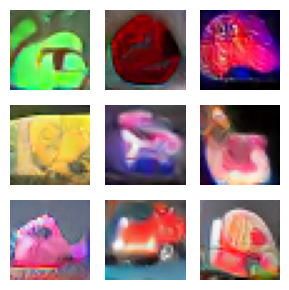

In [28]:
user_inputs = [
    "a grumpy blob emoji with half-closed eyes, smiling mouth, green skin, wearing a sombrero, red background",
    "a happy blob emoji with wide eyes, frowning mouth, red skin, pointing finger upwards, black background",
    "a sad blob emoji with teary eyes, wide open mouth showing tongue, orange skin, wearing a party hat, purple background",
    "a confused blob emoji with bright blue eyes, slightly open mouth, yellow skin, holding a large knife, white background",
    "a sleepy blob emoji with closed eyes, big smile, pink skin, wearing a rainbow hat, dark blue background",
    "an angry blob emoji with narrowed eyes, licking lips, white skin, sitting on a swing, warm background with fireplace",
    "a cool blob emoji with sunglasses, frowning mouth, purple skin, eating popcorn, light blue background with hearts",
    "a devilish blob emoji with red eyes, smiling mouth, brown skin, holding a steaming cup of coffee, white background",
    "a curious blob emoji with large round eyes, open mouth showing teeth, gray skin, hugging a teddy bear, red background",
]

fig, axes = plt.subplots(3, 3, figsize=(3, 3))
axes = axes.flatten()
for i, user_input in enumerate(user_inputs[:9]):
    prompt = f"A photo of {user_input.lower()}"
    img = generate_image(prompt, diffusion, vae, clip, noise_scheduler, num_inference_steps=100)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
